In [1]:
import random 
random.seed(42)

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from datetime import datetime
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import keras
from keras.layers import Dense, LSTM, Dropout, Bidirectional, Dense, Flatten, ConvLSTM2D, RepeatVector, TimeDistributed, SimpleRNN
from keras.layers.convolutional import Conv1D, Conv2D, MaxPooling1D, MaxPooling2D
from keras.models import Sequential
from keras.utils import to_categorical, np_utils
from keras.optimizers import SGD 
from keras.callbacks import EarlyStopping
import tensorflow as tf 
import tensorflow.keras.backend as K

2022-11-24 14:28:07.926392: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def process(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
    Pandas DataFrame of series framed for supervised learning.
    
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
            
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
        
    return agg

In [3]:
def Resample(data, criteria):
    
    if criteria == 'h':
        return data.resample('h').mean()
    
    if criteria == 'D':
        return data.resample('D').mean()

    if criteria == 'W':
        return data.resample('W').mean()

    if criteria == 'm':
        return data

In [4]:
def lstm_basic(inp_shape):
    
    model = Sequential()
#     model.add(SimpleRNN(units=64, input_shape=(inp_shape[1], inp_shape[2])))
    model.add((LSTM(64, activation='relu',return_sequences=True, input_shape=(inp_shape[1], inp_shape[2]))))
    model.add((LSTM(64, activation='relu')))
    model.add(Dense(64))
    model.add(Dropout(0.5))
    model.add(Dense(1))

    model.compile(optimizer='adam', loss='mse',metrics = ['mae','mse','mape'])
    
    return model 

In [5]:
def RNN_basic(inp_shape):
    
    model = Sequential()
    model.add(SimpleRNN(units=64, input_shape=(inp_shape[1], inp_shape[2])))
#     model.add((LSTM(64, activation='tanh',return_sequences=True, input_shape=(inp_shape[1], inp_shape[2]))))
#     model.add((LSTM(64, activation='relu')))
    model.add(Dense(64))
    model.add(Dropout(0.5))
    model.add(Dense(1))

    model.compile(optimizer='adam', loss='mse',metrics = ['mae','mse','mape'])
    
    return model 

In [6]:
def mean_absolute_percentage_error(y_true, y_pred):
    
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


In [7]:
def calculateMetrics(inv_y,inv_yhat):
    
    mse = mean_squared_error(inv_y, inv_yhat)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(inv_y, inv_yhat)
    mape = mean_absolute_percentage_error(inv_y, inv_yhat)
    
    return rmse, mse, mae, mape 

In [8]:
data = pd.read_csv("dataset.txt", delimiter=";", parse_dates={'dt' : ['Date', 'Time']}, infer_datetime_format=True,low_memory=False, na_values=['nan','?'], index_col='dt')

print("Data size:", data.shape)

#Number of missing data
data.isnull().sum(axis=0)
data = data.dropna(axis=0)
print(data.head())

Data size: (2075259, 7)
                     Global_active_power  Global_reactive_power  Voltage  \
dt                                                                         
2006-12-16 17:24:00                4.216                  0.418   234.84   
2006-12-16 17:25:00                5.360                  0.436   233.63   
2006-12-16 17:26:00                5.374                  0.498   233.29   
2006-12-16 17:27:00                5.388                  0.502   233.74   
2006-12-16 17:28:00                3.666                  0.528   235.68   

                     Global_intensity  Sub_metering_1  Sub_metering_2  \
dt                                                                      
2006-12-16 17:24:00              18.4             0.0             1.0   
2006-12-16 17:25:00              23.0             0.0             1.0   
2006-12-16 17:26:00              23.0             0.0             2.0   
2006-12-16 17:27:00              23.0             0.0             1.0   
2006-

In [9]:
sampled_data =  Resample(data , "h")
sampled_data.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
dt,,,,,,,
2006-12-16 17:00:00,4.222889,0.229000,234.643889,18.100000,0.0,0.527778,16.861111
2006-12-16 18:00:00,3.632200,0.080033,234.580167,15.600000,0.0,6.716667,16.866667
2006-12-16 19:00:00,3.400233,0.085233,233.232500,14.503333,0.0,1.433333,16.683333
2006-12-16 20:00:00,3.268567,0.075100,234.071500,13.916667,0.0,0.000000,16.783333
2006-12-16 21:00:00,3.056467,0.076667,237.158667,13.046667,0.0,0.416667,17.216667


In [10]:
#Preprocessing
values = sampled_data.values
values = values.astype('float32')

scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

reframed = process(values, 1, 1)
reframed.drop(reframed.columns[[8,9,10,11,12,13]], axis=1, inplace=True)
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var1(t)
1,4.222889,0.229000,234.643890,18.100000,0.0,0.527778,16.861111,3.632200
2,3.632200,0.080033,234.580170,15.600000,0.0,6.716667,16.866667,3.400233
3,3.400233,0.085233,233.232498,14.503333,0.0,1.433333,16.683332,3.268567
4,3.268567,0.075100,234.071503,13.916667,0.0,0.000000,16.783333,3.056467
5,3.056467,0.076667,237.158661,13.046667,0.0,0.416667,17.216667,2.200133


In [11]:
# split into train and test sets
values = reframed.values

train, test = train_test_split(values, train_size = 0.75, random_state = 10)

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

# We reshaped the input into the 3D format as expected by LSTMs, namely [samples, timesteps, features].
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape) 

(25619, 1, 7) (25619,) (8540, 1, 7) (8540,)


In [12]:
def model_lstm(train_X, train_y, test_X, test_y):
    print(train_X.shape)
    
    model = lstm_basic(train_X.shape)
    print(model.summary())
    
    history = model.fit(train_X, train_y, epochs=50, batch_size=70, validation_data=(test_X, test_y), verbose=2, shuffle=False)
    
    plt.plot(np.array(history.history['loss']))
    plt.plot(np.array(history.history['val_loss']))
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.show()
    

(25619, 1, 7)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 64)             18432     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 55,681
Trainable params: 55,681
Non-trainable params: 0
_________________________________________________________________
None


2022-11-24 14:28:29.445205: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/50
366/366 - 3s - loss: 0.4851 - mae: 0.5008 - mse: 0.4851 - mape: 70.5391 - val_loss: 0.3856 - val_mae: 0.4423 - val_mse: 0.3856 - val_mape: 62.0085 - 3s/epoch - 8ms/step
Epoch 2/50
366/366 - 1s - loss: 0.4166 - mae: 0.4625 - mse: 0.4166 - mape: 63.5736 - val_loss: 0.3757 - val_mae: 0.4286 - val_mse: 0.3757 - val_mape: 57.4006 - 954ms/epoch - 3ms/step
Epoch 3/50
366/366 - 1s - loss: 0.4072 - mae: 0.4563 - mse: 0.4072 - mape: 62.0457 - val_loss: 0.3726 - val_mae: 0.4464 - val_mse: 0.3726 - val_mape: 65.2091 - 950ms/epoch - 3ms/step
Epoch 4/50
366/366 - 1s - loss: 0.4069 - mae: 0.4563 - mse: 0.4069 - mape: 62.4941 - val_loss: 0.3816 - val_mae: 0.4230 - val_mse: 0.3816 - val_mape: 51.4140 - 954ms/epoch - 3ms/step
Epoch 5/50
366/366 - 1s - loss: 0.4050 - mae: 0.4541 - mse: 0.4050 - mape: 61.5757 - val_loss: 0.3818 - val_mae: 0.4153 - val_mse: 0.3818 - val_mape: 48.0042 - 949ms/epoch - 3ms/step
Epoch 6/50
366/366 - 1s - loss: 0.3988 - mae: 0.4505 - mse: 0.3988 - mape: 60.9471 - val

Epoch 46/50
366/366 - 1s - loss: 0.3600 - mae: 0.4261 - mse: 0.3600 - mape: 56.8827 - val_loss: 0.3588 - val_mae: 0.4081 - val_mse: 0.3588 - val_mape: 48.8659 - 947ms/epoch - 3ms/step
Epoch 47/50
366/366 - 1s - loss: 0.3600 - mae: 0.4256 - mse: 0.3600 - mape: 56.7956 - val_loss: 0.3541 - val_mae: 0.4193 - val_mse: 0.3541 - val_mape: 54.8286 - 947ms/epoch - 3ms/step
Epoch 48/50
366/366 - 1s - loss: 0.3614 - mae: 0.4271 - mse: 0.3614 - mape: 57.3255 - val_loss: 0.3572 - val_mae: 0.4142 - val_mse: 0.3572 - val_mape: 52.1875 - 945ms/epoch - 3ms/step
Epoch 49/50
366/366 - 1s - loss: 0.3584 - mae: 0.4246 - mse: 0.3584 - mape: 56.8113 - val_loss: 0.3576 - val_mae: 0.4112 - val_mse: 0.3576 - val_mape: 50.4922 - 946ms/epoch - 3ms/step
Epoch 50/50
366/366 - 1s - loss: 0.3600 - mae: 0.4255 - mse: 0.3600 - mape: 56.8201 - val_loss: 0.3578 - val_mae: 0.4092 - val_mse: 0.3578 - val_mape: 49.7486 - 941ms/epoch - 3ms/step


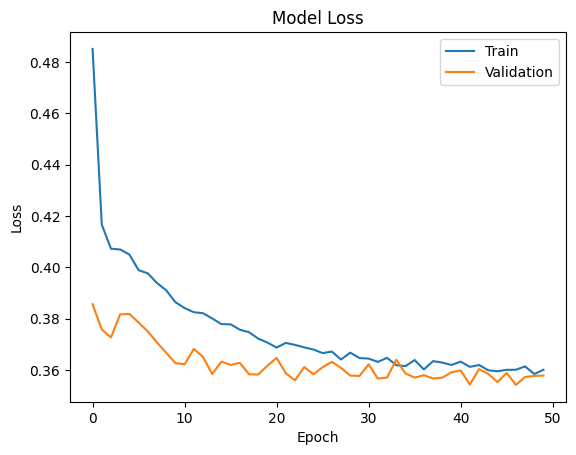

267/267 [==============================] - 1s 972us/step
0.59816706
Test MSE: 14.823
Test RMSE: 3.850
Test MAE: 2.634
Test MAPE: 47.657


In [13]:
model_lstm(train_X, train_y, test_X, test_y)

In [14]:
def model_RNN(train_X, train_y, test_X, test_y):
    print(train_X.shape)
    
    model = RNN_basic(train_X.shape)
    print(model.summary())
    
    history = model.fit(train_X, train_y, epochs=50, batch_size=70, validation_data=(test_X, test_y), verbose=2, shuffle=False)
    
    plt.plot(np.array(history.history['loss']))
    plt.plot(np.array(history.history['val_loss']))
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.show()
    
    # make a prediction
    yhat = model.predict(test_X)
    rmse, mse, mae, mape = calculateMetrics(test_y, yhat)
    print(rmse)
    test_X = test_X.reshape((test_X.shape[0], 7))
    
    # invert scaling for forecast
    inv_yhat = np.concatenate((yhat, test_X[:, -6:]), axis=1)
    inv_yhat = scaler.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:,0]
    
    # invert scaling for actual
    test_y = test_y.reshape((len(test_y), 1))
    inv_y = np.concatenate((test_y, test_X[:, -6:]), axis=1)
    inv_y = scaler.inverse_transform(inv_y)
    inv_y = inv_y[:,0] 
    
    rmse, mse, mae, mape = calculateMetrics(inv_y, inv_yhat)
    
    print("Test MSE: %.3f"%mse)
    print('Test RMSE: %.3f' % rmse)
    print("Test MAE: %.3f" % mae)
    print("Test MAPE: %.3f" % mape)

(25619, 1, 7)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 64)                4608      
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 8,833
Trainable params: 8,833
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
366/366 - 1s - loss: 0.6416 - mae: 0.5731 - mse: 0.6416 - mape: 84.6312 - val_loss: 0.4338 - val_mae: 0.4296 - val_mse: 0.4338 - val_mape: 41.3471 - 1s/ep

Epoch 41/50
366/366 - 1s - loss: 0.3776 - mae: 0.4390 - mse: 0.3776 - mape: 59.4891 - val_loss: 0.3625 - val_mae: 0.4198 - val_mse: 0.3625 - val_mape: 52.8349 - 528ms/epoch - 1ms/step
Epoch 42/50
366/366 - 1s - loss: 0.3762 - mae: 0.4375 - mse: 0.3762 - mape: 59.3894 - val_loss: 0.3642 - val_mae: 0.4214 - val_mse: 0.3642 - val_mape: 52.9892 - 524ms/epoch - 1ms/step
Epoch 43/50
366/366 - 1s - loss: 0.3778 - mae: 0.4380 - mse: 0.3778 - mape: 59.4149 - val_loss: 0.3650 - val_mae: 0.4247 - val_mse: 0.3650 - val_mape: 54.1968 - 525ms/epoch - 1ms/step
Epoch 44/50
366/366 - 1s - loss: 0.3764 - mae: 0.4381 - mse: 0.3764 - mape: 59.3148 - val_loss: 0.3627 - val_mae: 0.4271 - val_mse: 0.3627 - val_mape: 56.2519 - 524ms/epoch - 1ms/step
Epoch 45/50
366/366 - 1s - loss: 0.3766 - mae: 0.4389 - mse: 0.3766 - mape: 59.6242 - val_loss: 0.3628 - val_mae: 0.4285 - val_mse: 0.3628 - val_mape: 56.5779 - 525ms/epoch - 1ms/step
Epoch 46/50
366/366 - 1s - loss: 0.3779 - mae: 0.4388 - mse: 0.3779 - mape: 59.6

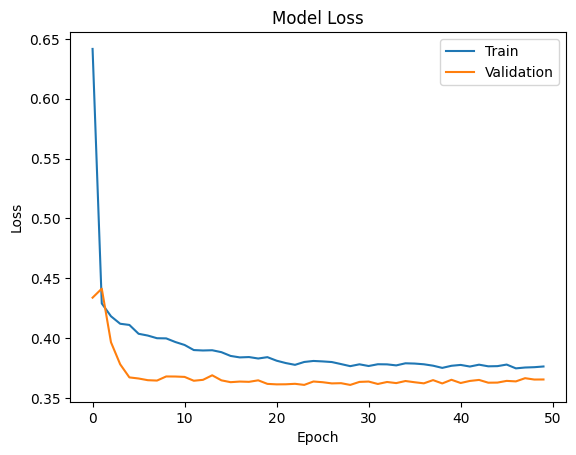

267/267 [==============================] - 0s 700us/step
0.6045038
Test MSE: 15.139
Test RMSE: 3.891
Test MAE: 2.730
Test MAPE: 51.838


In [15]:
model_RNN(train_X, train_y, test_X, test_y)